<a href="https://colab.research.google.com/github/AanchalA/MakeMore-with-Andrej-Karpathy/blob/main/MakeMoreNames_MLP_PyTorchifying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F

import random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# HyperParameters

In [ ]:
# HyperParameters

EPOCHS = 200000
BLOCK_SIZE = 3              ## Context Length: how many characters do we take to predict the next one?
BATCH_SIZE = 32
EMBEDDINGS_DIM = 10             ## Dimensionality of the Character Embedding Vectors
LEARNING_RATE = 0.1
NUM_HIDDEN_UNITS = 200          ## Number of Neurons in the Hidden Layer of the MLP
LEARNING_RATE_DECAY = 0.01

g = torch.Generator().manual_seed(2147483647)                   # for reproducibility

# Building the DataSet

In [ ]:
! wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-05-19 16:24:22--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.005s  

2023-05-19 16:24:23 (46.5 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words = open('names.txt').read().splitlines()
len(words)

32033

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
# stoi['<S>'] = 26
# stoi['<E>'] = 27
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)
print(f'{vocab_size}')

27


In [ ]:
def build_dataset(words):

    X, Y = list(), list()

    for w in words:

        # print(f"\nNAME: {w}")
        context = [0] * BLOCK_SIZE      ## [0, 0, 0]
        for ch in w + '.':              ## Appending '.' at the end of the name
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            # print('\t', ''.join(itos[i] for i in context), '--->', itos[ix])

            context = context[1:] + [ix]            ## POP from the top and then append

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)

    return X, Y

In [ ]:
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])                # 80%
Xdev, Ydev = build_dataset(words[n1:n2])            # 10%
Xte, Yte = build_dataset(words[n2:])                # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Model Preparation

In [ ]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in ** 0.5           ## Default Kaiming Initilization: (sqrt(fan_in)) - Even pytorch uses this as the default init.
        self.bias = torch.zeros(fan_out) if bias else None


    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out


    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [ ]:
class BatchNorm1D:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Parameters (Trained with Back-Prop)
        self.gamma = torch.ones(dim)               ## Batch Normalization Gain (Scaling Parameter)
        self.beta = torch.zeros(dim)               ##Batch Normalization Bias (Shifting Parameter)

        # Buffers (Trained with a "Running Momentum Update" or "Exponential Moving Average")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)


    def __call__(self, x):
        # Calculate the Forward Pass
        if self.training:
            xmean = x.mean(0, keepdims=True)                ## Batch Mean
            xvar = x.var(0, keepdims=True)                  ## Batch Variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)            ## Adding eps to xvar to avoide division by zero situation
        self.out = self.gamma * xhat + self.beta

        # Updating the Buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out


    def parameters(self):
        return [self.gamma, self.beta]

In [ ]:
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [ ]:
C = torch.randn((vocab_size, EMBEDDINGS_DIM), generator=g)
layers = [
    Linear(fan_in=EMBEDDINGS_DIM * BLOCK_SIZE,
           fan_out=NUM_HIDDEN_UNITS),
    BatchNorm1D(dim=NUM_HIDDEN_UNITS),
    Tanh(),
    Linear(fan_in=NUM_HIDDEN_UNITS,
           fan_out=NUM_HIDDEN_UNITS),
    BatchNorm1D(dim=NUM_HIDDEN_UNITS),
    Tanh(),
    Linear(fan_in=NUM_HIDDEN_UNITS,
           fan_out=NUM_HIDDEN_UNITS),
    BatchNorm1D(dim=NUM_HIDDEN_UNITS),
    Tanh(),
    Linear(fan_in=NUM_HIDDEN_UNITS,
           fan_out=NUM_HIDDEN_UNITS),
    BatchNorm1D(dim=NUM_HIDDEN_UNITS),
    Tanh(),
    Linear(fan_in=NUM_HIDDEN_UNITS,
           fan_out=NUM_HIDDEN_UNITS),
    BatchNorm1D(dim=NUM_HIDDEN_UNITS),
    Tanh(),
    Linear(fan_in=NUM_HIDDEN_UNITS,
           fan_out=vocab_size),
    BatchNorm1D(dim=vocab_size),
]

with torch.no_grad():
    # Last Layer: Make Less Confident (Fix for Softmax Confidently Wrong)
    # layers[-1].weight *= 0.1                ## Commenting this as NOW the last layer is a BatchNorm
    layers[-1].gamma *= 0.1

    # Applying Gain to All Other Layers (Fix for Tanh Layer too Saturated at Initilization)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 # 0.2 # 5/3                 # Gain for TanH. On top of default Kaiming ### 1.0 Means 0 gain (x*1=x)

In [ ]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]

# for layer in layers:
#     print(type(layer))
#     for p in layer.parameters():
#         print(p.nelement())

for p in parameters:
    p.requires_grad = True

print(f"Total Number of Parameters: {sum(p.nelement() for p in parameters)}")

Total Number of Parameters: 174751


# Model Training

In [ ]:
loss_i = list()
update_to_data_ratio = list()

for i in range(EPOCHS):

    # Mini Batch
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]           ## Batch X, Y


    # Forward Pass
    emb = C[Xb]                         ## Embed the Characters into Vectors
    x = emb.view(emb.shape[0], -1)      ## Concatenate the Vectors

    for layer in layers:
        x = layer(x)                    ## Applying __CALL__ for each layer type

    loss = F.cross_entropy(x, Yb)       ## Loss Function


    # Backward Pass
    for layer in layers:
        layer.out.retain_grad()         ## AFTER_DEBUG: Would comment out retain_grad

    for p in parameters:
        p.grad = None                   ## Resetting the gradients

    loss.backward()


    # Parameter Update
    lr = 1.0 # LEARNING_RATE if i < EPOCHS / 2 else LEARNING_RATE_DECAY
    for p in parameters:
        p.data += -lr * p.grad

    # Track Stats
    if i % 1000 == 0:
        print(f"{i:7d}/{EPOCHS:7d}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())

    with torch.no_grad():
        update_to_data_ratio.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # if i >= 1000:
    #     break

      0/ 200000: 3.2920
   1000/ 200000: 2.5508
   2000/ 200000: 2.2810
   3000/ 200000: 2.3705
   4000/ 200000: 2.4034
   5000/ 200000: 2.2506
   6000/ 200000: 1.9491
   7000/ 200000: 2.5223
   8000/ 200000: 2.2563
   9000/ 200000: 2.1707
  10000/ 200000: 2.0498
  11000/ 200000: 2.6457
  12000/ 200000: 2.2555
  13000/ 200000: 2.4093
  14000/ 200000: 2.5384
  15000/ 200000: 2.2373
  16000/ 200000: 1.9656
  17000/ 200000: 2.8003
  18000/ 200000: 2.4771
  19000/ 200000: 2.0899
  20000/ 200000: 2.5235
  21000/ 200000: 2.1853
  22000/ 200000: 2.3011
  23000/ 200000: 2.1316
  24000/ 200000: 2.2229
  25000/ 200000: 2.1356
  26000/ 200000: 2.0962
  27000/ 200000: 2.0606
  28000/ 200000: 2.5580
  29000/ 200000: 2.2729
  30000/ 200000: 2.2759
  31000/ 200000: 2.3182
  32000/ 200000: 2.1921
  33000/ 200000: 2.3707
  34000/ 200000: 1.8230
  35000/ 200000: 2.1702
  36000/ 200000: 1.7341
  37000/ 200000: 1.9498
  38000/ 200000: 2.5432
  39000/ 200000: 2.2068
  40000/ 200000: 2.2725
  41000/ 200000:

# Histogram Visualization of the Forward Pass Activations at TanH Layers

Layer 2. Tanh:                 Mean = -0.03,                 STD = 0.77,                 Saturated = 29.91%
Layer 5. Tanh:                 Mean = -0.03,                 STD = 0.78,                 Saturated = 27.61%
Layer 8. Tanh:                 Mean = 0.02,                 STD = 0.80,                 Saturated = 28.08%
Layer 11. Tanh:                 Mean = -0.01,                 STD = 0.81,                 Saturated = 31.31%
Layer 14. Tanh:                 Mean = 0.00,                 STD = 0.84,                 Saturated = 39.84%


Text(0.5, 1.0, 'Activation Distributions')

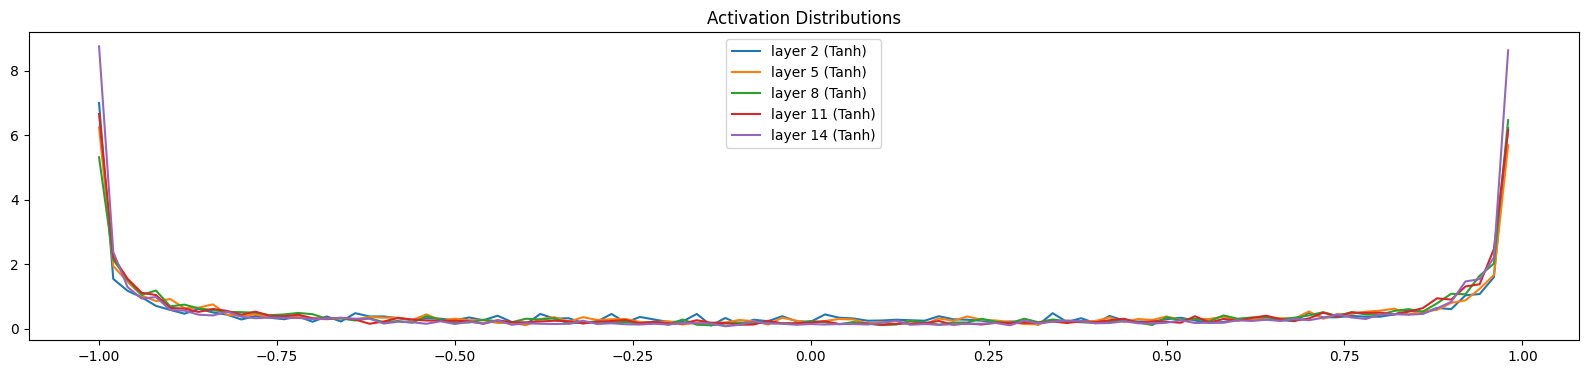

In [ ]:
plt.figure(figsize=(20, 4))
legends = list()

for i, layer in enumerate(layers[:-1]):             ## Excluding the Output Layer
    if isinstance(layer, Tanh):
        t = layer.out
        # Saturation: Percentage of values that are saturated at -1 or 1 (above abs(0.97))
        print(f"Layer {i}. {layer.__class__.__name__}: \
                Mean = {t.mean():.2f}, \
                STD = {t.std():.2f}, \
                Saturated = {(t.abs() > 0.97).float().mean()*100:.2f}%")

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('Activation Distributions')

# Histogram Visualization of the Gradients at TanH Layers

Layer 2. Tanh:                 Mean = +0.000000,                 STD = 2.551402e-03
Layer 5. Tanh:                 Mean = +0.000000,                 STD = 2.426720e-03
Layer 8. Tanh:                 Mean = +0.000000,                 STD = 2.324059e-03
Layer 11. Tanh:                 Mean = +0.000000,                 STD = 2.252202e-03
Layer 14. Tanh:                 Mean = +0.000000,                 STD = 2.717338e-03


Text(0.5, 1.0, 'Gradient Distributions')

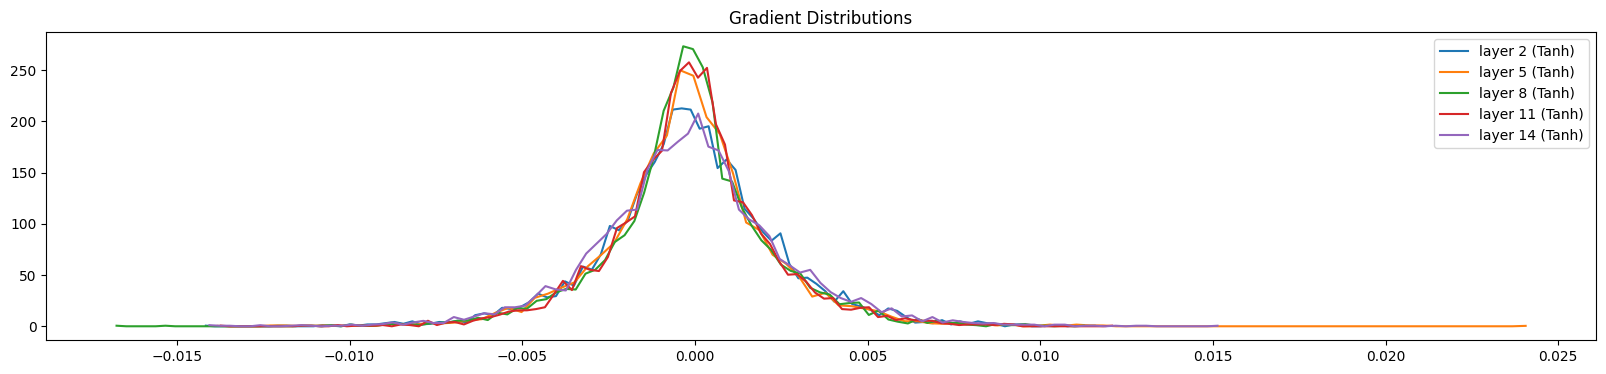

In [ ]:
plt.figure(figsize=(20, 4))
legends = list()

for i, layer in enumerate(layers[:-1]):             ## Excluding the Output Layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        # Saturation: Percentage of values that are saturated at -1 or 1 (above abs(0.97))
        print(f"Layer {i}. {layer.__class__.__name__}: \
                Mean = {t.mean():+f}, \
                STD = {t.std():e}")

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('Gradient Distributions')

# Historgam Visualization for Parameters of All Layers

Weight: (27, 10) | Mean: +0.000000 | STD: 5.480129e-03 | Grad:Data Ratio 1.683636e-03
Weight: (30, 200) | Mean: +0.000001 | STD: 1.938361e-03 | Grad:Data Ratio 1.389634e-03
Weight: (200, 200) | Mean: +0.000001 | STD: 7.210728e-04 | Grad:Data Ratio 6.855963e-04
Weight: (200, 200) | Mean: -0.000000 | STD: 6.770011e-04 | Grad:Data Ratio 6.485003e-04
Weight: (200, 200) | Mean: -0.000002 | STD: 6.332618e-04 | Grad:Data Ratio 6.068765e-04
Weight: (200, 200) | Mean: -0.000005 | STD: 5.856968e-04 | Grad:Data Ratio 5.674550e-04
Weight: (200, 27) | Mean: -0.000017 | STD: 1.791843e-03 | Grad:Data Ratio 1.419835e-03


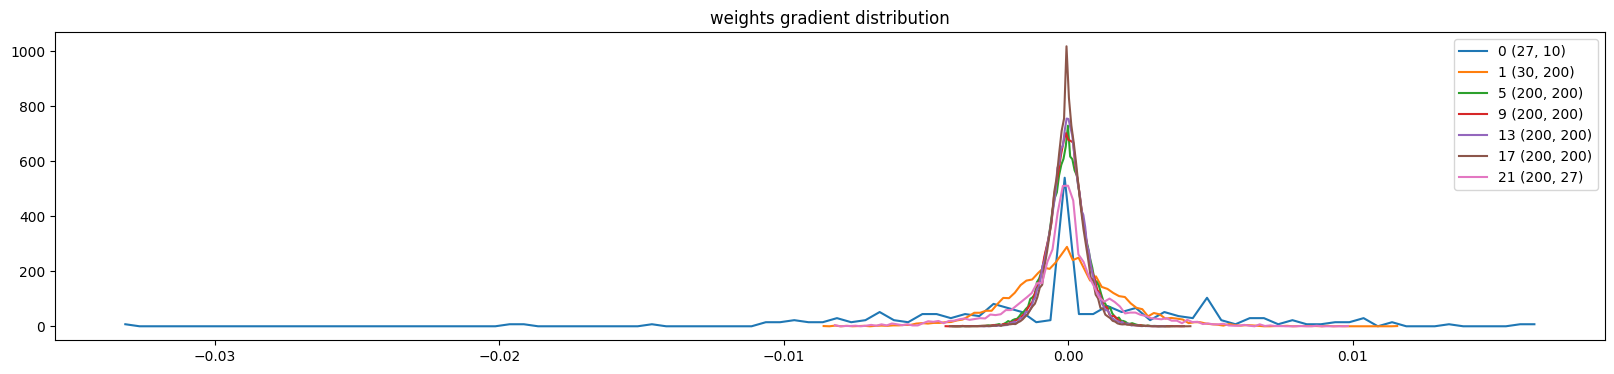

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = list()

for index, parameter in enumerate(parameters):
  t = parameter.grad

  if parameter.ndim == 2:           ## Not looking at things like - biases, gamma, beta (BatchNorm Parameters). Only looking at "Weights (2 Dimensional parameters)"

    print(f'Weight: {tuple(parameter.shape)} | Mean: {t.mean():+f} | STD: {t.std():e} | Grad:Data Ratio {t.std()/parameter.std():e}')

    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{index} {tuple(parameter.shape)}')

plt.legend(legends)
plt.title('weights gradient distribution');

# Histogram Visualization of Update to Data Ratio Over Time

- Plot helps in identifying the optimal learning rate
- The plot shows for fast each of the parameters are learning
- Most parameters show be learning at about the same rate

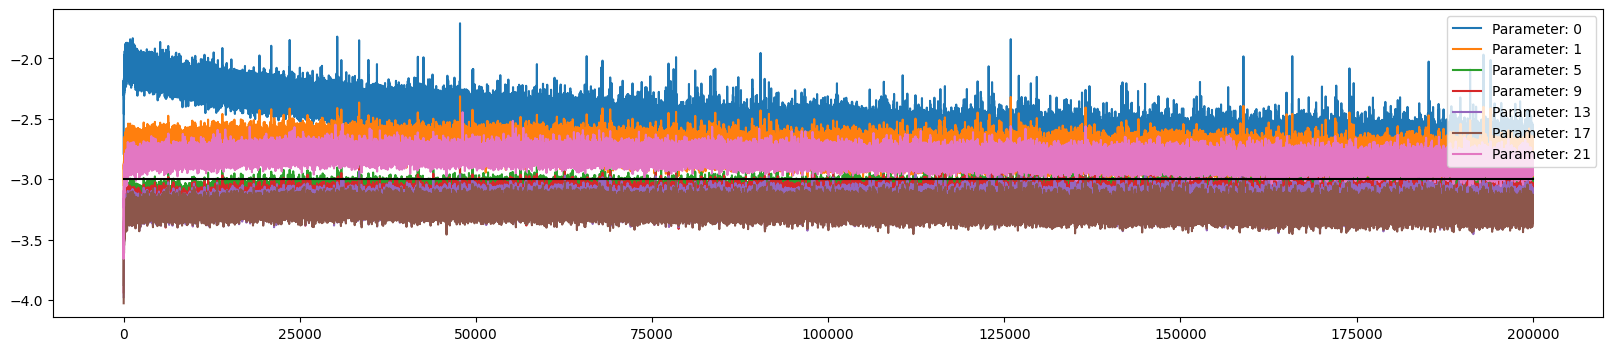

In [ ]:
plt.figure(figsize=(20, 4))
legends = list()

for index, parameter in enumerate(parameters):
  if parameter.ndim == 2:
    plt.plot([update_to_data_ratio[j][index] for j in range(len(update_to_data_ratio))])
    legends.append(f'Parameter: {index}')

plt.plot([0, len(update_to_data_ratio)], [-3, -3], 'k')         # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

# Loss on Train and Test Set

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.0087461471557617
val 2.1045286655426025


# Inference

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * BLOCK_SIZE # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

montaymyah.
see.
medhayla.
reish.
jendraegan.
chedielin.
shi.
jenne.
elieananar.
katelle.
keann.
shub.
roshiriel.
kin.
ron.
jerente.
cayus.
kynda.
jyseni.
eli.
